# Laboratorio di Simulazione Numerica: esercizio 11.1

Elia Steve (47122A)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

2024-10-01 15:36:35.004768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In questo esercizio dobbiamo investigare il ruolo di alcuni iperparametri (numero di epoche, numero di dati per il training, larghezza della gaussiana uasta per introdurre rumore nei dati) nella regressione lineare con una rete neurale a un neurone che usa l'identità per funzione di attivazione.

Costruisco il modello. Userò come metodo di ottimizzazione la discesa stocastica del gradiente e come funzione di costo l'errore quadratico medio: addizionalmente, terrò traccia anche del logaritmo del coseno iperbolico della differenza fra i dati di training e la predizione del modello (la metrica _"logcosh,"_ vedi https://keras.io/api/metrics/regression_metrics/#logcosherror-class).

In [2]:
keras.utils.set_random_seed(42)

model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1, )))

2024-10-01 15:37:03.488233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
model.compile(optimizer="sgd", loss="mse", metrics=["mse", "logcosh"])

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [5]:
#Save initial weights to start every optimization from the same state
initial_weights = model.get_weights()
initial_weights

[array([[1.2408034]], dtype=float32), array([0.], dtype=float32)]

Costruisco i dati di training e di validazione. Per le ascisse di validazione genero anche delle ordinate (i dati "target") senza rumore.

In [6]:
m = 2
b = 1
n_train = 500
n_valid = 50

rng = np.random.default_rng(seed=42)

In [7]:
sigma = 0.1

x_train = rng.uniform(-1, 1, n_train)
x_train.sort()
x_valid = rng.uniform(-1, 1, n_valid)

y_train = m*x_train + b + rng.normal(0, sigma, n_train)
y_valid = m*x_valid + b + rng.normal(0, sigma, n_valid)
y_target = m*x_valid+b

Definisco delle funzioni utili:

In [8]:
def test_model(model, x_valid, y_valid, y_target):
    """
    Performs a test of the model against validation data (with noise) and target data (without).
    
    Args:
        model: model to be tested
        x_valid: x-coordinates of validation and target data
        y_valid: y-coordinates of validation data
        y_target: y-coordinates of target data

    Returns:
        score_valid: scores of the model test with validation data
        score_target: scores of the model test with target data
    """
    score_valid = model.evaluate(x_valid, y_valid, batch_size=32, verbose=0)
    score_target = model.evaluate(x_valid, y_target, batch_size=32, verbose=0)

    return score_valid, score_target

def print_results(score_valid, score_target, weights, n_training_data, epochs, sigma):
    """
    Prints parameters of the model and resultsof tests

    Args:
        score_valid: scores of the model test with validation data
        score_target: scores of the model test with target data
        weights: weights of the model
        n_training_data: number of training data used
        epochs: number of epochs used for training
        sigma: width of the gaussian for noise creation
    """
    #print summary of training parameters
    print(40*"=")
    print("epochs =", epochs)
    print("number of training data =", n_training_data)
    print("sigma =", sigma)
    
    # print weights
    print(f"\nm = {weights[0][0][0]}, b={weights[1][0]}")

    # print performance
    print()
    print('Test loss (on validation data):', score_valid[0])
    print('Test logcosh (on validation data):', score_valid[2])
    print()
    print('Test loss (on target data):', score_target[0])
    print('Test logcosh (on target data):', score_target[2])
    print(40*"="+"\n")

Studio l'effetto della variazione del numero di iterazioni di training, addestrando il modello per 100 epoche e misurandone la preformance dopo 10, 30 e 70 iterazioni.

In [9]:
epochs = [10, 30, 70, 100]
prev_epochs=0
incremental_epochs = [10]

loss, validation_loss, logcosh = [], [], []

for i in range(len(epochs)-1):
    incremental_epochs.append(epochs[i+1]-epochs[i])

model.set_weights(initial_weights)

for incremental_epoch, epoch in zip(incremental_epochs, epochs):
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        epochs=incremental_epoch,
        shuffle=True,
        validation_data=(x_valid, y_valid),
        verbose=0
    )
    
    score_valid, score_target = test_model(model, x_valid, y_valid, y_target)
    
    print_results(score_valid, score_target, model.get_weights(), n_train, epoch, sigma)

    loss += history.history['loss']
    validation_loss += history.history['val_loss']
    logcosh += history.history["logcosh"]

epochs = 10
number of training data = 500
sigma = 0.1

m = 1.7362823486328125, b=0.9512705206871033

Test loss (on validation data): 0.03893005847930908
Test logcosh (on validation data): 0.019142447039484978

Test loss (on target data): 0.028478216379880905
Test logcosh (on target data): 0.01411290280520916

epochs = 30
number of training data = 500
sigma = 0.1

m = 1.9745932817459106, b=0.9935722351074219

Test loss (on validation data): 0.009530674666166306
Test logcosh (on validation data): 0.00473817577585578

Test loss (on target data): 0.0002844746923074126
Test logcosh (on target data): 0.00014221787569113076

epochs = 70
number of training data = 500
sigma = 0.1

m = 2.0071403980255127, b=0.9941484928131104

Test loss (on validation data): 0.009270371869206429
Test logcosh (on validation data): 0.004610363394021988

Test loss (on target data): 5.235653225099668e-05
Test logcosh (on target data): 2.618074358906597e-05

epochs = 100
number of training data = 500
sigma = 0.1

m =

Disegno un grafico delle varie metriche in funzione dell'epoca:

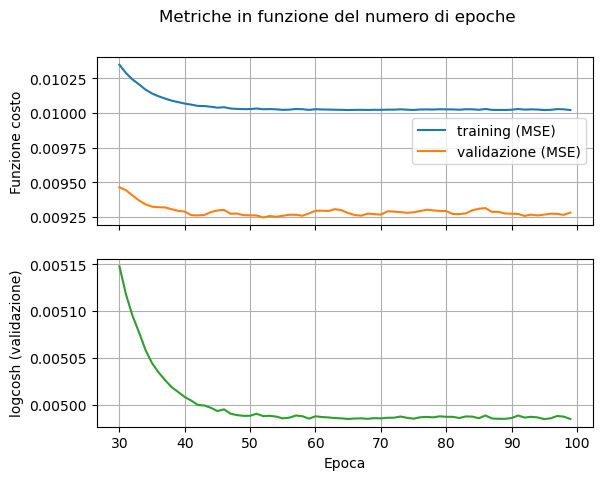

In [10]:
fig, axx = plt.subplots(2, 1, sharex=True)
fig.suptitle('Metriche in funzione del numero di epoche')

axx[0].plot(np.arange(30, 100), loss[30:], label="training (MSE)")
axx[0].plot(np.arange(30, 100), validation_loss[30:], label="validazione (MSE)")
axx[0].set_ylabel('Funzione costo')
axx[0].legend()
axx[0].grid()

axx[1].plot(np.arange(30, 100), logcosh[30:], color="tab:green")
axx[1].set_xlabel('Epoca')
axx[1].set_ylabel('logcosh (validazione)')
axx[1].grid()

plt.show()

Vediamo che dopo una rapida discesa iniziale, che non ho mostrato nel grafico, le metriche si attestano a valori più o meno costanti. Qui osserviamo dunque la tendenza per cui oltre a un certo punto nell'ottimizzazione non ci sono miglioramenti nel rendimento della rete (con modelli più complicati il rendimento può addirittura peggiorare se accade il fenomeno dell'overfitting, che nel nostro caso però non può insorgere dato che il nostro modello è semplicemente una retta). Per i test successivi ho deciso di addestrare i modelli con 50 epoche.

Confrontiamo le predizioni della rete con i dati target:

4/4 [==============================] - 0s 1ms/step


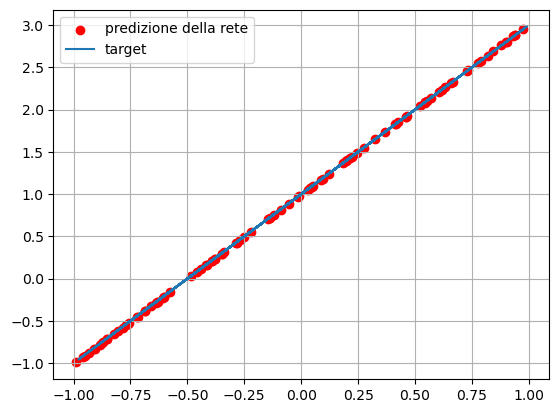

In [11]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label="predizione della rete")
plt.plot(x_valid, y_target, label="target")
plt.grid(True)
plt.legend()
plt.show()

Ora vediamo cosa succede variando la larghezza della distribuzione gaussiana che usiamo per aggiungere rumore ai dati di training:

In [12]:
sigmas = [0, 0.05, 0.1, 0.5, 1, 5]
n_epochs = 50
val_losses_sigma = []
target_losses_sigma = []
val_logcosh_sigma = []
target_logcosh_sigma = []

for sigma in sigmas:    
    model.set_weights(initial_weights)

    y_train = m*x_train + b + rng.normal(0, sigma, n_train)
    y_valid = m*x_valid + b + rng.normal(0, sigma, n_valid)

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=32,
        epochs=n_epochs,
        shuffle=True,
        validation_data=(x_valid, y_valid),
        verbose=0
    )
    
    score_valid, score_target = test_model(model, x_valid, y_valid, y_target)
    val_losses_sigma += [score_valid[0]]
    target_losses_sigma += [score_target[0]]
    val_logcosh_sigma += [score_valid[2]]
    target_logcosh_sigma += [score_target[2]]
    
    print_results(score_valid, score_target, model.get_weights(), n_train, n_epochs, sigma)
    #print(score_valid, score_target)

epochs = 50
number of training data = 500
sigma = 0

m = 1.9960322380065918, b=0.9999629259109497

Test loss (on validation data): 5.85534144192934e-06
Test logcosh (on validation data): 2.9289722078829072e-06

Test loss (on target data): 5.85534144192934e-06
Test logcosh (on target data): 2.9289722078829072e-06

epochs = 50
number of training data = 500
sigma = 0.05

m = 2.0000550746917725, b=0.9936869740486145

Test loss (on validation data): 0.002438904019072652
Test logcosh (on validation data): 0.0012173056602478027

Test loss (on target data): 3.9848629967309535e-05
Test logcosh (on target data): 1.9930601411033422e-05

epochs = 50
number of training data = 500
sigma = 0.1

m = 2.002009630203247, b=1.002971887588501

Test loss (on validation data): 0.00947624258697033
Test logcosh (on validation data): 0.0047136349603533745

Test loss (on target data): 1.0452074093336705e-05
Test logcosh (on target data): 5.226135272096144e-06

epochs = 50
number of training data = 500
sigma = 0.

In [13]:
def draw_bar_chart(labels, val_losses, target_losses, val_logcosh, target_logcosh, x_label, title):
    """
    Draws a bar chart with various metrics for each case of hyperparameters used during training.

    Args:
        labels: values of the hyperparameters used during training. Used as labels for the ticks of the x-axis
        val_losses: loss on validation data for each of the hyperparameters
        target_losses: loss on target data for each of the hyperparameters
        val_logcosh: logcosh on validation data for each of the hyperparameters
        target_logcosh: logcosh on target data for each of the hyperparameters
        x_label: label for the x-axis
        title: title of the plot
    """
    
    assert len(labels) == len(val_losses)
    assert len(labels) == len(target_losses)
    
    x = np.arange(len(labels))
    width = 0.20

    fig, ax = plt.subplots(layout='constrained')

    #Only two categories, don't need to loop
    rects = ax.bar(x, val_losses, width, label="MSE sui dati di validazione")
    rects = ax.bar(x+width, val_logcosh, width, label="logcosh sui dati di validazione")
    rects = ax.bar(x+2*width, target_losses, width, label="MSE sui dati target")
    rects = ax.bar(x+3*width, target_logcosh, width, label="logcosh sui dati target")

    ax.set_yscale("log")
    ax.set_xticks(x+1.5*width, labels)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Funzione costo")
    ax.set_title(title)
    ax.legend()

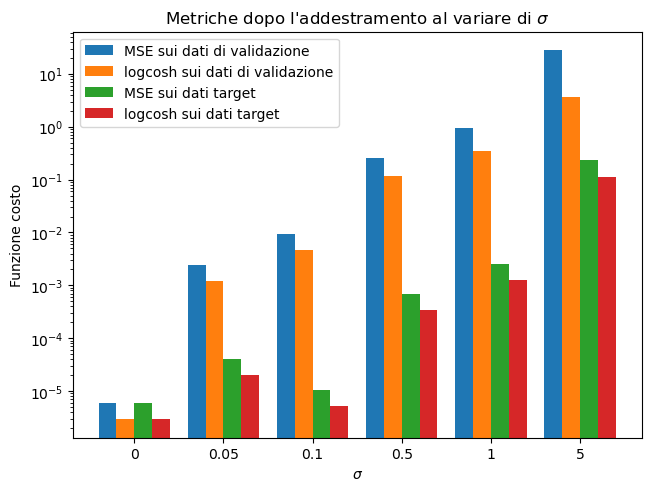

In [18]:
draw_bar_chart(sigmas, val_losses_sigma, target_losses_sigma, val_logcosh_sigma, target_logcosh_sigma, r"$\sigma$", r"Metriche dopo l'addestramento al variare di $\sigma$")

Qui vediamo (come ci si poteva aspettare) che introdurre rumore nel dati di training degrada progressivamente le previsioni del modello, sia sui dati di validazione (rumorosi) che su quelli di target (senza rumore).

Ora vediamo cosa cambia variando il numero di dati di training:

In [15]:
sigma = 0.05
n_epochs = 50
increments = 6
datapts_per_increment = 100

val_losses_training = []
target_losses_training = []
val_logcosh_training = []
target_logcosh_training = []

x_train_2 = np.array([])
y_train_2 = np.array([])

for i in range(increments):    
    model.set_weights(initial_weights)

    additional_xs = rng.uniform(-1, 1, datapts_per_increment)
    #print(additional_xs)
    x_train_2 = np.concatenate((x_train_2, additional_xs))
    additional_ys = m*additional_xs + b + rng.normal(0, sigma, datapts_per_increment)
    y_train_2 = np.concatenate((y_train_2, additional_ys))

    #plt.scatter(x_train_2, y_train_2, marker = ".")
    #plt.show()

    history = model.fit(
        x=x_train_2,
        y=y_train_2,
        batch_size=32,
        epochs=n_epochs,
        shuffle=True,
        validation_data=(x_valid, y_valid),
        verbose=1
    )
    
    score_valid, score_target = test_model(model, x_valid, y_valid, y_target)
    
    print_results(score_valid, score_target, model.get_weights(), len(x_train_2), n_epochs, sigma)

    val_losses_training += [score_valid[0]]
    target_losses_training += [score_target[0]]
    val_logcosh_training += [score_valid[2]]
    target_logcosh_training += [score_target[2]]

Epoch 1/50
4/4 [==============================] - 0s 21ms/step - loss: 1.0787 - mse: 1.0787 - logcosh: 0.4365 - val_loss: 28.5714 - val_mse: 28.5714 - val_logcosh: 3.6452
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 0.9452 - mse: 0.9452 - logcosh: 0.3887 - val_loss: 28.5749 - val_mse: 28.5749 - val_logcosh: 3.6479
Epoch 3/50
4/4 [==============================] - 0s 12ms/step - loss: 0.8158 - mse: 0.8158 - logcosh: 0.3414 - val_loss: 28.5836 - val_mse: 28.5836 - val_logcosh: 3.6508
Epoch 4/50
4/4 [==============================] - 0s 12ms/step - loss: 0.7048 - mse: 0.7048 - logcosh: 0.2996 - val_loss: 28.6045 - val_mse: 28.6045 - val_logcosh: 3.6544
Epoch 5/50
4/4 [==============================] - 0s 19ms/step - loss: 0.6149 - mse: 0.6149 - logcosh: 0.2650 - val_loss: 28.6226 - val_mse: 28.6226 - val_logcosh: 3.6575
Epoch 6/50
4/4 [==============================] - 0s 11ms/step - loss: 0.5387 - mse: 0.5387 - logcosh: 0.2350 - val_loss: 28.6491 - val_mse: 28.6

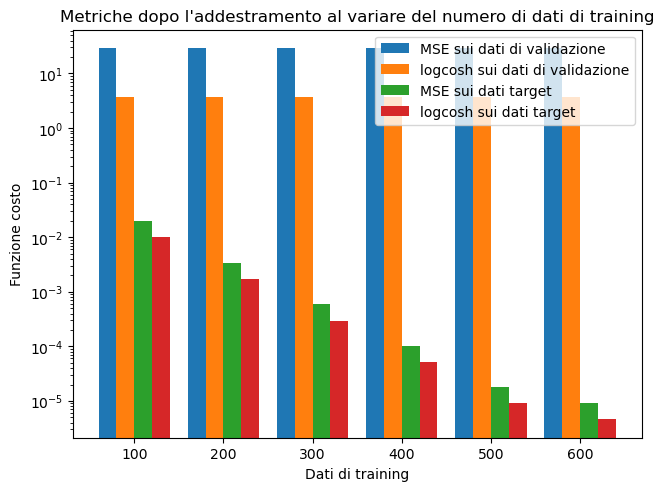

In [19]:
no_of_training_datas = [datapts_per_increment*(i+1) for i in range(increments)]
draw_bar_chart(
    no_of_training_datas,
    val_losses_training,
    target_losses_training,
    val_logcosh_training,
    target_logcosh_training,
    "Dati di training",
    "Metriche dopo l'addestramento al variare del numero di dati di training"
)

Qui vediamo che al crescere del numero dei dati di training il rendimento del modello sui dati target migliora, mentre invece il rendimento sui dati di validazione resta più o meno analogo: questo è un comportamento anomalo che probabilmente è dovuto al fatto che stiamo usando un modello estremamente semplice (due parametri senza funzione di attivazione).